# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, avg, count, sum, min, max, desc, asc, col, variance, when, round
from pyspark.sql import Window
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier, GBTClassifier
import numpy as np
import pandas as pd
import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName('mini project') \
        .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

In [7]:
df.describe(['sessionId', 'userId']).show()

+-------+-----------------+-----------------+
|summary|        sessionId|           userId|
+-------+-----------------+-----------------+
|  count|           286500|           286500|
|   mean|1041.526554973822|59682.02278593872|
| stddev|726.7762634630741|109091.9499991047|
|    min|                1|                 |
|    max|             2474|               99|
+-------+-----------------+-----------------+



In [7]:
for column in df.columns:
    print('The {} column has {} blank records.'.format(column, df.filter((df[column]=='') | (df[column]==np.nan)).count()))

The artist column has 0 blank records.
The auth column has 0 blank records.
The firstName column has 0 blank records.
The gender column has 0 blank records.
The itemInSession column has 0 blank records.
The lastName column has 0 blank records.
The length column has 0 blank records.
The level column has 0 blank records.
The location column has 0 blank records.
The method column has 0 blank records.
The page column has 0 blank records.
The registration column has 0 blank records.
The sessionId column has 0 blank records.
The song column has 0 blank records.
The status column has 0 blank records.
The ts column has 0 blank records.
The userAgent column has 0 blank records.
The userId column has 8346 blank records.


观察发现有userId为空的无效数据，这些数据产生在用户未登陆的状态，与后面预测用户流失或留存的需求无关，故可以删去

In [4]:
df = df.filter(df.userId != '')

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

##### gender

In [9]:
df.select('userId', 'gender').dropDuplicates().groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



##### level

In [10]:
df.select('userId', 'level').dropDuplicates().groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



有些用户拥有2个level

##### page

In [11]:
df.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



##### artist

In [12]:
df.select('artist').groupBy('artist').count().orderBy(desc('count')).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



##### Location

In [9]:
location_state = udf(lambda x: x.split(',')[-1].strip())
df = df.withColumn('locationState', location_state(df.location))

In [14]:
df.select('userId', 'locationState').dropDuplicates().groupBy('locationState').count().orderBy(desc('count')).collect()

[Row(locationState='CA', count=33),
 Row(locationState='TX', count=16),
 Row(locationState='NY-NJ-PA', count=15),
 Row(locationState='FL', count=14),
 Row(locationState='AZ', count=7),
 Row(locationState='CT', count=7),
 Row(locationState='NC', count=6),
 Row(locationState='IL-IN-WI', count=6),
 Row(locationState='MO-IL', count=6),
 Row(locationState='NC-SC', count=6),
 Row(locationState='MI', count=5),
 Row(locationState='NY', count=5),
 Row(locationState='PA-NJ-DE-MD', count=5),
 Row(locationState='MA-NH', count=5),
 Row(locationState='WA', count=4),
 Row(locationState='AL', count=4),
 Row(locationState='DC-VA-MD-WV', count=4),
 Row(locationState='GA', count=4),
 Row(locationState='CO', count=4),
 Row(locationState='MN-WI', count=3),
 Row(locationState='KY', count=3),
 Row(locationState='NV', count=3),
 Row(locationState='IL', count=3),
 Row(locationState='MS', count=3),
 Row(locationState='IN', count=3),
 Row(locationState='OH', count=3),
 Row(locationState='PA', count=3),
 Row(loca

##### Define churned user

In [5]:
churn_lst = []
churn_user = df.select('userId').filter(df.page=="Cancellation Confirmation").collect()
for i in range(len(churn_user)):
    churn_lst.append(churn_user[i][0])
churn = udf(lambda x: 1 if x in churn_lst else 0, IntegerType())
df = df.withColumn('Churn', churn(df.userId))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

In [ ]:
# Use Window to mark user
churn_event = udf(lambda x: 1 if df.page==1 else 0, IntegerType())
df = df.withColumn('churn_event', churn_event(df.page))

windowval = Window.partionBy("userId")
df = df.withColumn('Churn', max(df.churn_event).over(windowval))
# groupby userId, if the userId has churn event, then the userId is marked as Churn = 1

In [11]:
df.select('userId', 'Churn').dropDuplicates().groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [12]:
total_user_number = df.select('userId').dropDuplicates().count()
churn_number = df.select('userId', 'Churn').filter(df.Churn==1).dropDuplicates().count()
stay_number = df.select('userId', 'Churn').filter(df.Churn==0).dropDuplicates().count()

In [19]:
df.select('userId', 'firstname', 'page', 'song', 'level').where(df.userId=='30').collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)', level='paid'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None, level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album

In [20]:
df.select('userId', 'firstname', 'page', 'song', 'level').where(df.userId=='18').collect()

[Row(userId='18', firstname='Adriel', page='Home', song=None, level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='A Beggar On A Beach Of Gold', level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='...slowdance On The Inside (Album Version)', level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='St. Apollonia', level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='Drunk Stripper', level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='In League With Satan', level='paid'),
 Row(userId='18', firstname='Adriel', page='Settings', song=None, level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='The Quest', level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='Waking The Demon', level='paid'),
 Row(userId='18', firstname='Adriel', page='NextSong', song='Why Do You Let Me Stay Here?', level='paid'),
 Row(userId='18', firstname='Adriel', pag

##### Define downgrade user

In [6]:
down_lst = []
down_user = df.select('userId').filter(df.page=="Downgrade").collect()
for i in range(len(down_user)):
    down_lst.append(down_user[i][0])
down = udf(lambda x: 1 if x in down_lst else 0, IntegerType())
df = df.withColumn('Downgrade', down(df.userId))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, Downgrade=1)

In [14]:
df.select('userId', 'Downgrade').dropDuplicates().groupBy('Downgrade').count().show()

+---------+-----+
|Downgrade|count|
+---------+-----+
|        1|  154|
|        0|   71|
+---------+-----+



In [15]:
downgrade_number = df.select('userId', 'Downgrade').filter(df.Downgrade==1).dropDuplicates().count()
upgrade_number = df.select('userId', 'Downgrade').filter(df.Downgrade==0).dropDuplicates().count()

##### Define year, month, day, hour , active_time for each user

In [16]:
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).year, IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day, IntegerType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())

df = df.withColumn('year', get_year(df.ts))
df = df.withColumn('month', get_month(df.ts))
df = df.withColumn('day', get_day(df.ts))
df = df.withColumn('hour', get_hour(df.ts))

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', locationState='CA', Churn=0, Downgrade=1, year=2018, month=10, day=1, hour=0)

In [25]:
df.describe(['hour', 'day', 'month', 'year']).show()

+-------+-----------------+------------------+------------------+------+
|summary|             hour|               day|             month|  year|
+-------+-----------------+------------------+------------------+------+
|  count|           278154|            278154|            278154|278154|
|   mean|12.20457372534639|15.793574782314833|10.479022412045126|2018.0|
| stddev|6.865469990132577| 8.926525825029135|0.4995894305896185|   0.0|
|    min|                0|                 1|                10|  2018|
|    max|               23|                31|                12|  2018|
+-------+-----------------+------------------+------------------+------+



观察到数据来源于2018年10月1日至12月31日

### 留存用户与流失用户组之间比较

##### 活跃时间比较

In [26]:
range_day = udf(lambda x: datetime.timedelta(0, x/1000.0).days, IntegerType())
df_time_range = df.select('userId', 'ts').groupBy('userId').agg(max(col('ts'))-min(col('ts')))
df_time_range = df_time_range.withColumn('range_day', range_day(df_time_range['(max(ts) - min(ts))']))
df_time_range = df_time_range.withColumn('Churn', churn(df_time_range.userId))
df_time_range.groupBy('Churn').agg(avg(col('range_day'))).show()

+-----+------------------+
|Churn|    avg(range_day)|
+-----+------------------+
|    1|23.134615384615383|
|    0| 46.52023121387283|
+-----+------------------+



观察发现留存用户组的平均活跃时间是流失用户组活跃时间的2倍左右

用户平均活跃时间（天）：

In [27]:
avg_time = df_time_range.select('range_day').agg(avg('range_day')).collect()[0][0]
avg_time

41.11555555555555

流失用户组与留存用户组平均活跃时间（天）：

In [28]:
df_range = df_time_range.groupBy('Churn').agg(avg(col('range_day')))
avg_churn_time = df_range.select('avg(range_day)').where(df_range.Churn==1).collect()[0][0]
avg_stay_time = df_range.select('avg(range_day)').where(df_range.Churn==0).collect()[0][0]
print(avg_churn_time, avg_stay_time)

23.134615384615383 46.52023121387283


要探索分析留存用户组与流失用户组之间的特征差异，要排除两组之间人数的差别以及平均活跃时间不同这两个因素。

因为后续使用机器学习方法的目的是预测用户流失的概率，以对流失概率高的用户采取一定的优惠措施。机器学习方法针对的是个体而不是总体，所以两组之间的样本数量差异会干扰机器学习方法的特征选取。在预测的时候某名用户在未来留存或流失是未知的，所以样本每名用户的活跃时间对机器学习方法没有参考价值

基于控制变量的考虑排除两组之间人数的差别以及平均活跃时间不同这两个因素可以更好地考察两组之间其他特征的差异（如播放音乐的数量）

##### 播放音乐数量比较

每名用户平均播放音乐：

In [30]:
df.filter(df.page=='NextSong').groupBy('Churn').count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1| 36394|
|    0|191714|
+-----+------+



如果不考虑留存用户组与流失用户组的区别，每组应播放音乐数量：

In [31]:
avg_song_number_per_day = df.filter(df.page=='NextSong').count() / (total_user_number*avg_time)
print('For churned user group, the number of total song played should be {}'.format(churn_number*avg_churn_time*avg_song_number_per_day))
print('For stayed user group, the number of total song played should be {}'.format(stay_number*avg_stay_time*avg_song_number_per_day))

For churned user group, the number of total song played should be 29663.163333693657
For stayed user group, the number of total song played should be 198444.83666630636


In [32]:
df1 = df.filter(df.page=='NextSong').groupBy('Churn','userId').count()
df2 = df1.groupBy('Churn').agg(avg(col('count')), variance(col('count')))
df2.show()

churned_mean = df2.select('avg(count)').where(df.Churn==1).collect()[0][0] / avg_churn_time
stayed_mean = df2.select('avg(count)').where(df.Churn==0).collect()[0][0] / avg_stay_time
churned_var = df2.select('var_samp(count)').where(df.Churn==1).collect()[0][0] / np.square(avg_churn_time)
stayed_var = df2.select('var_samp(count)').where(df.Churn==0).collect()[0][0] / np.square(avg_stay_time)

diff = churned_mean - stayed_mean
total_var = churned_var + stayed_var*(churn_number/stay_number)
z_score = diff / np.sqrt(total_var)
# print(z_score)
p_value = 2 * (1-norm.cdf(z_score))
p_value

+-----+------------------+------------------+
|Churn|        avg(count)|   var_samp(count)|
+-----+------------------+------------------+
|    1| 699.8846153846154| 510849.9079939669|
|    0|1108.1734104046243|1399836.1209167896|
+-----+------------------+------------------+



0.84951201770020157

可以发现流失用户组播放的音乐数量总和多于预期，预期来源于留存用户组与流失用户组平均每个用户每天播放的音乐数量相等的假设。用户每天平均播放音乐数量可以作为预测未来用户留存或流失的特征之一。经过实践发现这里不必应用假设检验去发现有用特征，因为假设检验基于总体，会考虑到样本之间的偏差，而机器学习方法只考虑个体，不会考虑总体

**hour比较**

In [33]:
df_stay = df.filter(df.Churn==0)
df_churn = df.filter(df.Churn==1)

df_stay_pd = df_stay.groupBy('hour').count().orderBy(asc('hour')).toPandas()
df_stay_pd['count'] = df_stay_pd['count']/df_stay_pd['count'].sum()
df_stay_pd = df_stay_pd.rename(columns={'count': 'stay_group'})

df_churn_pd = df_churn.groupBy('hour').count().orderBy(asc('hour')).toPandas()
df_churn_pd['count'] = df_churn_pd['count']/df_churn_pd['count'].sum()
df_churn_pd = df_churn_pd.rename(columns={'count': 'churn_group'})

hour_pd = pd.concat([df_stay_pd, df_churn_pd.iloc[:,1]], axis=1)
hour_pd

,hour,stay_group,churn_group
0,0,0.039256,0.042818
1,1,0.036470,0.036577
2,2,0.036298,0.036265
3,3,0.036641,0.035173
4,4,0.036157,0.033858
5,5,0.036487,0.033368
6,6,0.035707,0.032788
7,7,0.035677,0.032944
8,8,0.036410,0.033568
9,9,0.037447,0.033011


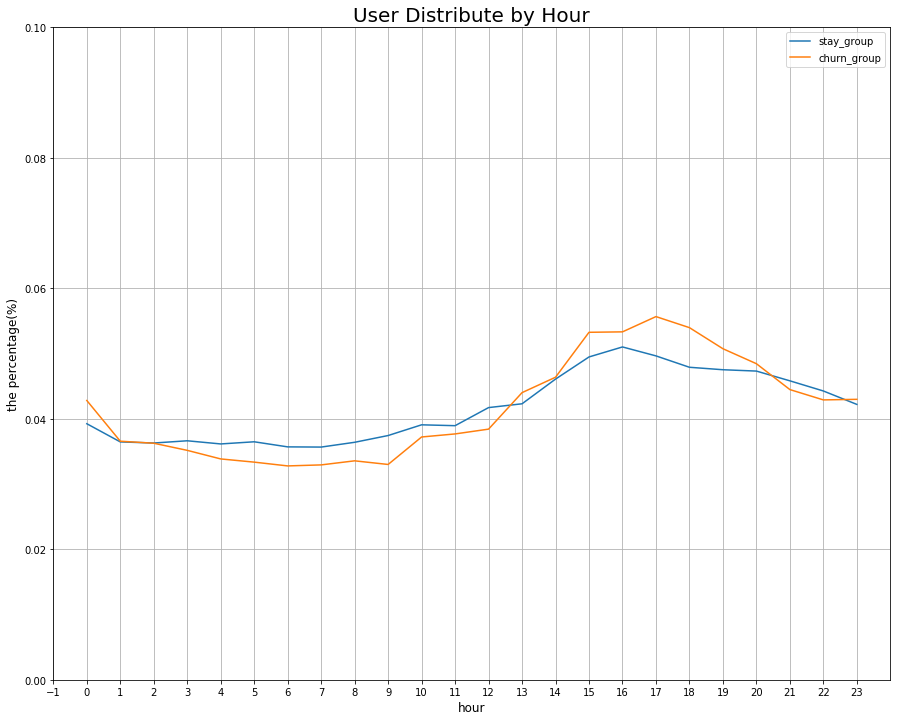

In [34]:
hour_pd.plot(x='hour', y=['stay_group', 'churn_group'], figsize=(15,12), 
             grid=True, legend=True, xlim=(-1, 24), ylim=(0, 0.1), xticks=np.arange(-1, 24, 1), fontsize=10)
plt.xlabel('hour', size=12)
plt.ylabel('the percentage(%)', size=12)
plt.title('User Distribute by Hour', size=20);

**month比较**

In [35]:
df_stay_pd = df_stay.groupBy('month').count().orderBy(asc('month')).toPandas()
df_stay_pd['count'] = df_stay_pd['count']/df_stay_pd['count'].sum()
df_stay_pd = df_stay_pd.rename(columns={'count': 'stay_group'})

df_churn_pd = df_churn.groupBy('month').count().orderBy(asc('month')).toPandas()
df_churn_pd['count'] = df_churn_pd['count']/df_churn_pd['count'].sum()
df_churn_pd = df_churn_pd.rename(columns={'count': 'churn_group'})

month_pd = pd.concat([df_stay_pd, df_churn_pd.iloc[:,1]], axis=1)
month_pd

,month,stay_group,churn_group
0,10,0.462442,0.82545
1,11,0.537541,0.17455
2,12,0.000017,NaN


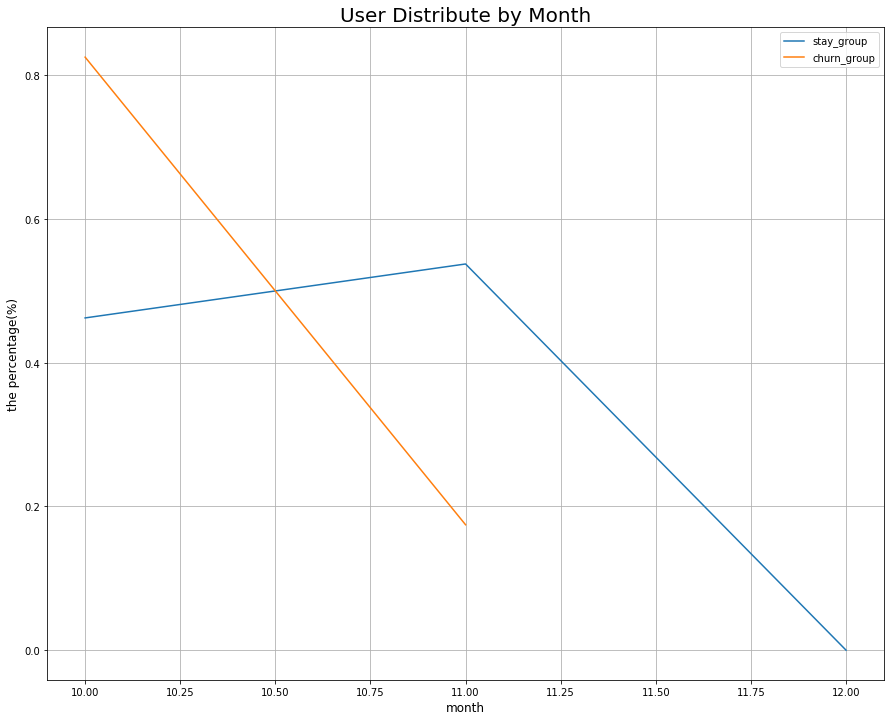

In [36]:
month_pd.plot(x='month', y=['stay_group', 'churn_group'], figsize=(15,12), 
             grid=True, legend=True, fontsize=10)
plt.xlabel('month', size=12)
plt.ylabel('the percentage(%)', size=12)
plt.title('User Distribute by Month', size=20);

流失用户大多数出现在10月

**level数量比较**

In [37]:
df_stay_pd = df_stay.select('userId', 'level').dropDuplicates().groupBy('level').count().toPandas()
df_stay_pd['count'] = df_stay_pd['count']/df_stay_pd['count'].sum()
df_stay_pd = df_stay_pd.rename(columns={'count': 'stay_group'})

df_churn_pd = df_churn.select('userId', 'level').dropDuplicates().groupBy('level').count().toPandas()
df_churn_pd['count'] = df_churn_pd['count']/df_churn_pd['count'].sum()
df_churn_pd = df_churn_pd.rename(columns={'count': 'churn_group'})

level_pd = pd.merge(df_stay_pd, df_churn_pd, on='level')
level_pd

,level,stay_group,churn_group
0,free,0.535971,0.560976
1,paid,0.464029,0.439024


可以发现流失用户组与留存用户组用户level分布大致相同

In [38]:
df_stay_pd = df_stay.select('userId', 'gender').dropDuplicates().groupBy('gender').count().toPandas()
df_stay_pd['count'] = df_stay_pd['count']/df_stay_pd['count'].sum()
df_stay_pd = df_stay_pd.rename(columns={'count': 'stay_group'})

df_churn_pd = df_churn.select('userId', 'gender').dropDuplicates().groupBy('gender').count().toPandas()
df_churn_pd['count'] = df_churn_pd['count']/df_churn_pd['count'].sum()
df_churn_pd = df_churn_pd.rename(columns={'count': 'churn_group'})

gender_pd = pd.merge(df_stay_pd, df_churn_pd, on='gender')
gender_pd

,gender,stay_group,churn_group
0,F,0.485549,0.384615
1,M,0.514451,0.615385


可以发现流失用户组与留存用户组相比男性占更大比例，性别可以作为预测用户流失或留存的特征之一

**Trumbs Down & Trumbs Up数量比较**

In [39]:
df.filter(df.page=='Thumbs Down').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  496|
|    0| 2050|
+-----+-----+



In [40]:
avg_thumbs_down_per_day = df.filter(df.page=='Thumbs Down').count() / (total_user_number*avg_time)
print('For churned user group, the number of total thumbs down should be {}.'.format(churn_number*avg_churn_time*avg_thumbs_down_per_day))
print('For stayed user group, the number of total thumbs down should be {}.'.format(stay_number*avg_stay_time*avg_thumbs_down_per_day))

For churned user group, the number of total thumbs down should be 331.0818289914604.
For stayed user group, the number of total thumbs down should be 2214.9181710085395.


可以发现流失用户组Thumbs Down数量多于预期，预期来源于留存用户组与流失用户组平均每个用户每天Thumbs Down数量相等的假设。用户平均每天Thumbs Down数量可以作为预测用户流失或留存的特征之一。

In [41]:
df.filter(df.page=='Thumbs Up').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 1859|
|    0|10692|
+-----+-----+



In [42]:
avg_thumbs_up_per_day = df.filter(df.page=='Thumbs Up').count() / (total_user_number*avg_time)
print('For churned user group, the number of total thumbs up should be {}.'.format(churn_number*avg_churn_time*avg_thumbs_up_per_day))
print('For stayed user group, the number of total thumbs up should be {}.'.format(stay_number*avg_stay_time*avg_thumbs_up_per_day))

For churned user group, the number of total thumbs up should be 1632.1319857312724.
For stayed user group, the number of total thumbs up should be 10918.868014268728.


可以发现流失用户组Thumbs Up数量总和大致符合预期，预期来源于留存用户组与流失用户组平均每个用户每天Thumbs Up数量相等的假设

**Roll Advert数量比较**

In [43]:
df.filter(df.page=='Roll Advert').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  967|
|    0| 2966|
+-----+-----+



In [44]:
avg_roll_advert_per_day = df.filter(df.page=='Roll Advert').count() / (total_user_number*avg_time)
print('For churned user group, the number of total roll advert should be {}.'.format(churn_number*avg_churn_time*avg_roll_advert_per_day))
print('For stayed user group, the number of total roll advert should be {}.'.format(stay_number*avg_stay_time*avg_roll_advert_per_day))

For churned user group, the number of total roll advert should be 511.4473029942709.
For stayed user group, the number of total roll advert should be 3421.5526970057294.


可以发现流失用户组Roll Advert数量总和明显多于预期，预期来源于留存用户组与流失用户组平均每个用户每天Roll Advert数量相等的假设。所以，用户每天平均Roll Advert的次数可以作为预测未来留存或流失的重要特征

**Submit Downgrade数量比较**

In [45]:
df.filter(df.page=='Submit Downgrade').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|    9|
|    0|   54|
+-----+-----+



In [46]:
avg_submit_downgrade_per_day = df.filter(df.page=='Submit Downgrade').count() / (total_user_number*avg_time)
print('For churned user group, the number of total submit downgrade should be {}.'.format(churn_number*avg_churn_time*avg_submit_downgrade_per_day))
print('For stayed user group, the number of total submit downgrade should be {}.'.format(stay_number*avg_stay_time*avg_submit_downgrade_per_day))

For churned user group, the number of total submit downgrade should be 8.192519727597016.
For stayed user group, the number of total submit downgrade should be 54.807480272402984.


可以发现流失用户组Submit Downgrade数量总和大致符合预期，预期来源于留存用户组与流失用户组平均每个用户每天Submit Downgrade数量相等的假设

**Downgrade数量比较**

In [47]:
df.filter(df.page=='Downgrade').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  337|
|    0| 1718|
+-----+-----+



In [48]:
avg_downgrade_per_day = df.filter(df.page=='Downgrade').count() / (total_user_number*avg_time)
print('For churned user group, the number of total downgrade should be {}.'.format(churn_number*avg_churn_time*avg_downgrade_per_day))
print('For stayed user group, the number of total downgrade should be {}.'.format(stay_number*avg_stay_time*avg_downgrade_per_day))

For churned user group, the number of total downgrade should be 267.2321911144741.
For stayed user group, the number of total downgrade should be 1787.767808885526.


可以发现流失用户组Downgrade数量多于预期，预期来源于留存用户组与流失用户组平均每个用户每天Downgrade数量相等的假设。用户平均每天Downgrade数量可以作为预测用户流失或留存的特征之一

**Add to Playlist数量比较**

In [49]:
df.filter(df.page=='Add to Playlist').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 1038|
|    0| 5488|
+-----+-----+



In [50]:
avg_add_to_playlist_per_day = df.filter(df.page=='Add to Playlist').count() / (total_user_number*avg_time)
print('For churned user group, the number of total add to playlist should be {}.'.format(churn_number*avg_churn_time*avg_add_to_playlist_per_day))
print('For stayed user group, the number of total add to playlist should be {}.'.format(stay_number*avg_stay_time*avg_add_to_playlist_per_day))

For churned user group, the number of total add to playlist should be 848.64101178251.
For stayed user group, the number of total add to playlist should be 5677.358988217489.


可以发现流失用户组Add to Playlist数量多于预期，预期来源于留存用户组与流失用户组平均每个用户每天Add to Playlist数量相等的假设。用户平均每天Add to Playlist数量可以作为预测用户流失或留存的特征之一

**Add Friend数量比较**

In [51]:
df.filter(df.page=='Add Friend').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  636|
|    0| 3641|
+-----+-----+



In [52]:
avg_add_friend_per_day = df.filter(df.page=='Add Friend').count() / (total_user_number*avg_time)
print('For churned user group, the number of total add_friend should be {}.'.format(churn_number*avg_churn_time*avg_add_friend_per_day))
print('For stayed user group, the number of total add_friend should be {}.'.format(stay_number*avg_stay_time*avg_add_friend_per_day))

For churned user group, the number of total add_friend should be 556.1810615068641.
For stayed user group, the number of total add_friend should be 3720.8189384931356.


可以发现流失用户组Add Friend数量总和大致符合预期，预期来源于留存用户组与流失用户组平均每个用户每天Add Friend数量相等的假设

**Help数量比较**

In [53]:
df.filter(df.page=='Help').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  239|
|    0| 1215|
+-----+-----+



In [54]:
avg_help_per_day = df.filter(df.page=='Help').count() / (total_user_number*avg_time)
print('For churned user group, the number of total help should be {}.'.format(churn_number*avg_churn_time*avg_help_per_day))
print('For stayed user group, the number of total help should be {}.'.format(stay_number*avg_stay_time*avg_help_per_day))

For churned user group, the number of total help should be 189.0781537131121.
For stayed user group, the number of total help should be 1264.921846286888.


可以发现流失用户组Help数量多于预期，预期来源于留存用户组与流失用户组平均每个用户每天Help数量相等的假设。用户平均每天Help数量可以作为预测用户流失或留存的特征之一

**Settings数量比较**

In [55]:
df.filter(df.page=='Settings').groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  270|
|    0| 1244|
+-----+-----+



In [56]:
avg_settings_per_day = df.filter(df.page=='Settings').count() / (total_user_number*avg_time)
print('For churned user group, the number of total settings should be {}.'.format(churn_number*avg_churn_time*avg_settings_per_day))
print('For stayed user group, the number of total settings should be {}.'.format(stay_number*avg_stay_time*avg_settings_per_day))

For churned user group, the number of total settings should be 196.8805534536807.
For stayed user group, the number of total settings should be 1317.1194465463193.


可以发现流失用户组Setings数量多于预期，预期来源于留存用户组与流失用户组平均每个用户每天Setings数量相等的假设。用户平均每天Setings数量可以作为预测用户流失或留存的特征之一

### 综上所述

**经过探索性分析，有以下特征可以用来预测未来用户留存或流失：**

1 用户每天平均Roll Advert的数量

2 性别

3 用户平均每天Thumbs Down数量

4 用户平均每天Downgrade数量

5 用户每天平均播放音乐数量

6 用户平均每天Add to Playlist数量

7 用户平均每天Help数量

8 用户平均每天Setings数量

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [7]:
range_second = udf(lambda x: datetime.timedelta(0, x/1000.0).seconds, IntegerType())
range_day = udf(lambda x: datetime.timedelta(0, x/1000.0).days, IntegerType())
df_feature = df.select('userId', 'ts', 'page', 'gender').groupBy('userId') \
            .agg(max(col('ts'))-min(col('ts')), count(col('page')), count(when(df.page=='Roll Advert', 1)), \
                count(when(df.page=='Thumbs Down', 1)), count(when(df.page=='Downgrade', 1)), \
                count(when(df.page=='NextSong', 1)), count(when(df.page=='Add to Playlist', 1)), \
                count(when(df.page=='Help', 1)), count(when(df.page=='Settings', 1)), min(df.gender))

df_feature = df_feature.withColumn('second', range_second(df_feature['(max(ts) - min(ts))']))
df_feature = df_feature.withColumn('day', range_day(df_feature['(max(ts) - min(ts))']))
df_feature = df_feature.withColumn('Churn', churn(df_feature.userId))
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Roll Advert) THEN 1 END)', 'Roll Advert')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Thumbs Down) THEN 1 END)', 'Thumbs Down')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Downgrade) THEN 1 END)', 'Downgrade')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = NextSong) THEN 1 END)', 'Song Number')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Add to Playlist) THEN 1 END)', 'Add to Playlist')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Help) THEN 1 END)', 'Help')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Settings) THEN 1 END)', 'Settings')
df_feature = df_feature.withColumnRenamed('min(gender)', 'gender')
df_feature = df_feature.withColumn('time', df_feature.day+df_feature.second/(3600*24))
df_feature = df_feature.select('userId', 'gender', 'Roll Advert', 'Thumbs Down', 'Downgrade', 'Song Number', \
                              'Add to Playlist', 'Help', 'Settings', 'time', 'Churn')
df_feature.show()

+------+------+-----------+-----------+---------+-----------+---------------+----+--------+-------------------+-----+
|userId|gender|Roll Advert|Thumbs Down|Downgrade|Song Number|Add to Playlist|Help|Settings|               time|Churn|
+------+------+-----------+-----------+---------+-----------+---------------+----+--------+-------------------+-----+
|100010|     F|         52|          5|        0|        275|              7|   2|       0|  44.21780092592593|    0|
|200002|     M|          7|          6|        5|        387|              8|   2|       3| 45.496805555555554|    0|
|   125|     M|          1|          0|        0|          8|              0|   0|       0|0.02053240740740741|    1|
|   124|     F|          4|         41|       41|       4079|            118|  23|      20| 59.996944444444445|    0|
|    51|     M|          0|         21|       23|       2111|             52|  12|      12| 15.779398148148148|    1|
|     7|     M|         16|          1|        0|       

In [8]:
df_feature = df_feature.withColumn('Roll Advert', df_feature['Roll Advert']/df_feature.time)
df_feature = df_feature.withColumn('Thumbs Down', df_feature['Thumbs Down']/df_feature.time)
df_feature = df_feature.withColumn('Downgrade', df_feature['Downgrade']/df_feature.time)
df_feature = df_feature.withColumn('Song Number', df_feature['Song Number']/df_feature.time)
df_feature = df_feature.withColumn('Add to Playlist', df_feature['Add to Playlist']/df_feature.time)
df_feature = df_feature.withColumn('Help', df_feature['Help']/df_feature.time)
df_feature = df_feature.withColumn('Settings', df_feature['Settings']/df_feature.time)

df_feature.take(5)

[Row(userId='100010', gender='F', Roll Advert=1.1759969720590784, Thumbs Down=0.11307663192875753, Downgrade=0.0, Song Number=6.219214756081664, Add to Playlist=0.15830728470026054, Help=0.04523065277150301, Settings=0.0, time=44.21780092592593, Churn=0),
 Row(userId='200002', gender='M', Roll Advert=0.15385695576917793, Thumbs Down=0.13187739065929538, Downgrade=0.10989782554941281, Song Number=8.506091697524552, Add to Playlist=0.17583652087906051, Help=0.04395913021976513, Settings=0.06593869532964769, time=45.496805555555554, Churn=0),
 Row(userId='125', gender='M', Roll Advert=48.70349492671927, Thumbs Down=0.0, Downgrade=0.0, Song Number=389.6279594137542, Add to Playlist=0.0, Help=0.0, Settings=0.0, time=0.02053240740740741, Churn=1),
 Row(userId='124', gender='F', Roll Advert=0.06667006190130052, Thumbs Down=0.6833681344883304, Downgrade=0.6833681344883304, Song Number=67.98679562385121, Add to Playlist=1.9667668260883655, Help=0.38335285593247803, Settings=0.33335030950650263,

In [9]:
df_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Song Number: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- time: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [10]:
indexer1 = StringIndexer(inputCol='gender', outputCol='gender_')
vectorassembler1 = VectorAssembler(inputCols=df_feature.columns[2:-2], outputCol='features_')
scale = StandardScaler(inputCol='features_', outputCol='features__', withMean=True, withStd=True)
vectorassembler2 = VectorAssembler(inputCols=['gender_','features__'], outputCol='features')
indexer2 = StringIndexer(inputCol='Churn', outputCol='label')

pipeline = Pipeline(stages=[indexer1, vectorassembler1, scale, vectorassembler2, indexer2])

pModel = pipeline.fit(df_feature)
df_feature_ = pModel.transform(df_feature)
df_feature_ = df_feature_.select('userId', 'features', 'label')
df_feature_.take(5)

[Row(userId='100010', features=DenseVector([1.0, -0.1231, -0.1833, -0.4801, -0.4555, -0.2609, -0.2015, -0.1127]), label=0.0),
 Row(userId='200002', features=DenseVector([0.0, -0.1832, -0.1772, -0.2684, -0.4307, -0.2574, -0.2028, -0.1081]), label=0.0),
 Row(userId='125', features=DenseVector([0.0, 2.6718, -0.2197, -0.4801, 3.7108, -0.2925, -0.249, -0.1127]), label=1.0),
 Row(userId='124', features=DenseVector([1.0, -0.1883, 0.0006, 0.8365, 0.2157, 0.1005, 0.1535, -0.0894]), label=0.0),
 Row(userId='51', features=DenseVector([0.0, -0.1923, 0.2093, 2.3281, 0.9306, 0.366, 0.5494, -0.0595]), label=1.0)]

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [11]:
train, test = df_feature_.randomSplit([0.8, 0.2], seed=42)

**LogisticRegression:**

In [25]:
lr = LogisticRegression(maxIter=50)
paraGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0, 10.0]).build()
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
lrModel = crossval.fit(train)
lrModel.avgMetrics

[0.7503477923896313,
 0.7079684306004542,
 0.6979238170062102,
 0.6728011381499422,
 0.6672542264410412]

In [26]:
results_lr = lrModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator(metricName="f1")
evaluator.evaluate(results_lr)

0.7262656475019387

**LinearSVC:**

In [12]:
lsvc = LinearSVC(maxIter=10)
paraGrid = ParamGridBuilder().addGrid(lsvc.regParam, [0.0, 0.01, 0.1, 1.0, 10.0]).build()
crossval = CrossValidator(estimator=lsvc, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
lsvcModel = crossval.fit(train)
lsvcModel.avgMetrics

[0.6718858723292166,
 0.6746103649619661,
 0.6746103649619661,
 0.6746103649619661,
 0.6669236548021041]

In [13]:
results_lsvc = lsvcModel.bestModel.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName="f1")
evaluator.evaluate(results_lsvc)

0.6627450980392157

**RandomForest:**

In [17]:
rf = RandomForestClassifier(seed=42)
paraGrid = ParamGridBuilder().addGrid(rf.numTrees, np.arange(10, 51, 10)) \
        .addGrid(rf.maxDepth, np.arange(3, 7, 2)).build()
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
rfModel = crossval.fit(train)
rfModel.avgMetrics

[0.7084293972590091,
 0.7367708800076632,
 0.7343319087574733,
 0.738964267147197,
 0.7195265047095962,
 0.750152287845443,
 0.7230920751382789,
 0.7388096551669346,
 0.7499720710523341,
 0.7445294668039908]

In [18]:
results_rf = rfModel.bestModel.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName="f1")
evaluator.evaluate(results_rf)

0.8259686649779528

**GradientBoost:**

In [14]:
gb = GBTClassifier(seed=42)
paraGrid = ParamGridBuilder().addGrid(gb.stepSize, [0.01, 0.1]) \
        .addGrid(gb.maxDepth, np.arange(3, 7, 2)).build()
crossval = CrossValidator(estimator=gb, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
gbModel = crossval.fit(train)
gbModel.avgMetrics

[0.7711513232272813,
 0.7275329648579651,
 0.7632415490579285,
 0.7263904033573674]

In [15]:
results_gb = gbModel.bestModel.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName="f1")
evaluator.evaluate(results_gb)

0.706288032454361

In [19]:
results_rf.filter(results_rf.prediction == results_rf.label).count() / results_rf.count()

0.8529411764705882

使用了LogisticRegression,LinearSVC,RandomForest,GradientBoosting 四种分类器，对其进行交叉验证以及网格参数选取，比较发现RandomForest的f1-score分数最高，达到了0.826。这里选择f1-score作为评估指标，因为数据集中的标签分布不均匀，项目中重点关注的Churn用户占少数，所以综合考虑precission/recall的f1-score评估指标更为合适

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。